In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# Load the dataset
data_path = "Soybean.csv"
df = pd.read_csv(data_path)

# Basic dataset info
print("Dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum().sort_values(ascending=False))

# Check the target variable distribution
print("\nTarget variable distribution:")
print(df['Class'].value_counts())

# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Handle missing values
# For this dataset, we'll use mode for categorical variables
for col in X.columns:
    if X[col].dtype == 'object':
        # Fill categorical missing values with mode
        mode_value = X[col].mode()[0] if not X[col].mode().empty else 'missing'
        X[col].fillna(mode_value, inplace=True)
    else:
        # Fill numerical missing values with median
        X[col].fillna(X[col].median(), inplace=True)

# Store original column names for reference
original_columns = X.columns.tolist()

# Label encode categorical features
label_encoders = {}
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

# Convert to numpy array
X = X.values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=5,
    n_jobs=-1
)

Dataset shape: (683, 36)

Column names:
['Class', 'date', 'plant.stand', 'precip', 'temp', 'hail', 'crop.hist', 'area.dam', 'sever', 'seed.tmt', 'germ', 'plant.growth', 'leaves', 'leaf.halo', 'leaf.marg', 'leaf.size', 'leaf.shread', 'leaf.malf', 'leaf.mild', 'stem', 'lodging', 'stem.cankers', 'canker.lesion', 'fruiting.bodies', 'ext.decay', 'mycelium', 'int.discolor', 'sclerotia', 'fruit.pods', 'fruit.spots', 'seed', 'mold.growth', 'seed.discolor', 'seed.size', 'shriveling', 'roots']

First few rows:
                   Class  date  plant.stand  precip  temp  hail  crop.hist  \
0  diaporthe-stem-canker   6.0          0.0     2.0   1.0   0.0        1.0   
1  diaporthe-stem-canker   4.0          0.0     2.0   1.0   0.0        2.0   
2  diaporthe-stem-canker   3.0          0.0     2.0   1.0   0.0        1.0   
3  diaporthe-stem-canker   3.0          0.0     2.0   1.0   0.0        1.0   
4  diaporthe-stem-canker   6.0          0.0     2.0   1.0   0.0        2.0   

   area.dam  sever  seed.

In [3]:
# Fit the model
print("\nTraining the model...")
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Training the model...

Model Accuracy: 0.9708

Classification Report:
                             precision    recall  f1-score   support

               2-4-d-injury       1.00      1.00      1.00         3
        alternarialeaf-spot       0.90      1.00      0.95        18
                anthracnose       1.00      0.89      0.94         9
           bacterial-blight       1.00      1.00      1.00         4
          bacterial-pustule       1.00      1.00      1.00         4
                 brown-spot       0.95      1.00      0.97        18
             brown-stem-rot       1.00      1.00      1.00         9
               charcoal-rot       1.00      1.00      1.00         4
              cyst-nematode       1.00      1.00      1.00         3
diaporthe-pod-&-stem-blight       1.00      1.00      1.00         3
      diaporthe-stem-canker       1.00      1.00      1.00         4
               downy-mildew       1.00      1.00      1.00         4
         frog-eye-leaf-spot    

In [4]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': original_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Top 10 Most Important Features:
          feature  importance
21  canker.lesion    0.081647
0            date    0.074893
14      leaf.size    0.054255
34          roots    0.051423
28    fruit.spots    0.050784
27     fruit.pods    0.047692
20   stem.cankers    0.047356
12      leaf.halo    0.047073
10   plant.growth    0.044731
25   int.discolor    0.039188


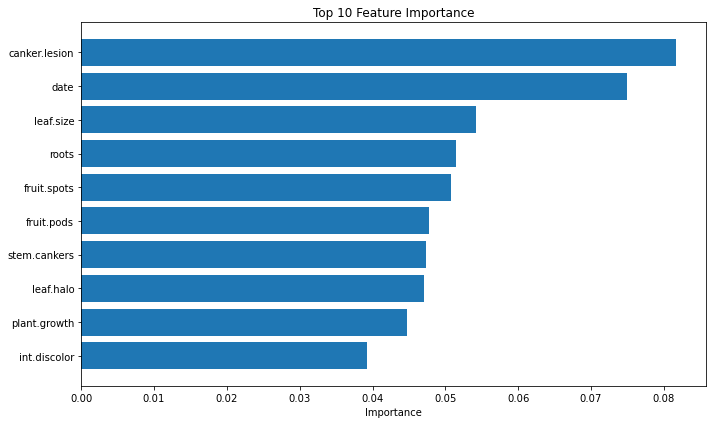

In [5]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

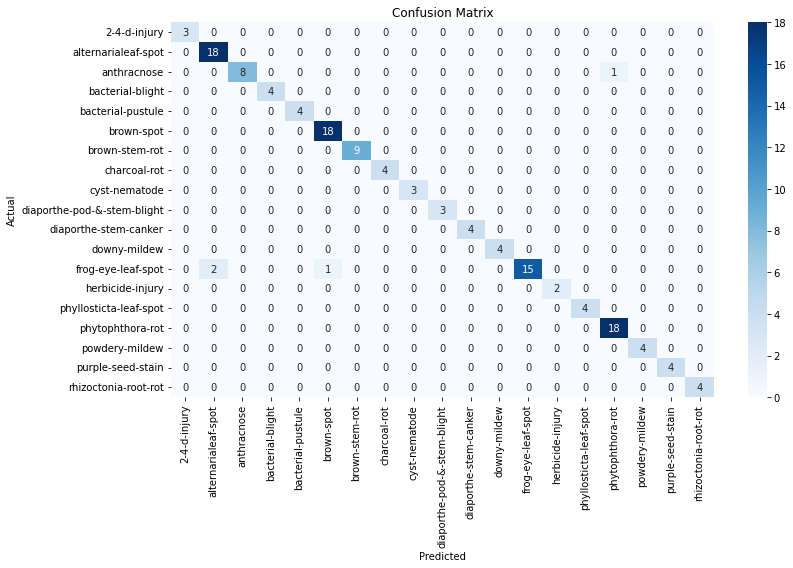

In [6]:
# Confusion Matrix
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, 
            yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

In [7]:
# Create directory for saving models
os.makedirs('soybean_models', exist_ok=True)

# Save the model and preprocessors
joblib.dump(model, 'soybean_models/soybean_model.pkl')
joblib.dump(scaler, 'soybean_models/scaler.pkl')
joblib.dump(label_encoders, 'soybean_models/label_encoders.pkl')
joblib.dump(original_columns, 'soybean_models/feature_names.pkl')

# Save the unique classes
joblib.dump(model.classes_, 'soybean_models/classes.pkl')

print("\nModel and preprocessors saved successfully!")


Model and preprocessors saved successfully!


In [8]:
# Define prediction function for Streamlit
def predict_soybean_disease(features_dict):
    """
    Predict soybean disease based on input features
    features_dict: dictionary with feature names as keys and values
    """
    # Create a DataFrame with the same structure as training data
    input_df = pd.DataFrame([features_dict])
    
    # Handle missing values
    for col in input_df.columns:
        if input_df[col].isna().any():
            if col in label_encoders:
                input_df[col].fillna('missing', inplace=True)
            else:
                input_df[col].fillna(0, inplace=True)
    
    # Apply label encoding
    for col in input_df.columns:
        if col in label_encoders:
            # Handle unseen labels
            le = label_encoders[col]
            # Get the value
            value = input_df[col].iloc[0]
            if value in le.classes_:
                input_df[col] = le.transform([value])[0]
            else:
                # Assign a default value for unseen labels
                input_df[col] = 0
    
    # Ensure all columns are present
    for col in original_columns:
        if col not in input_df.columns:
            input_df[col] = 0
    
    # Reorder columns to match training data
    input_df = input_df[original_columns]
    
    # Scale the features
    features_scaled = scaler.transform(input_df.values)
    
    # Make prediction
    prediction = model.predict(features_scaled)[0]
    probabilities = model.predict_proba(features_scaled)[0]
    
    # Get probability for each class
    class_probabilities = {cls: prob for cls, prob in zip(model.classes_, probabilities)}
    
    return {
        'prediction': prediction,
        'confidence': max(probabilities),
        'probabilities': class_probabilities
    }

In [9]:
# Test the prediction function
# Example: Create a sample input
sample_features = {col: X_test[0][i] for i, col in enumerate(original_columns)}
result = predict_soybean_disease(sample_features)

print("\nTest Prediction:")
print(f"Predicted Disease: {result['prediction']}")
print(f"Confidence: {result['confidence']:.4f}")
print("\nProbabilities for all classes:")
for cls, prob in result['probabilities'].items():
    print(f"{cls}: {prob:.4f}")

# Save a sample of the data for reference
df_sample = df.head(10)
df_sample.to_csv('soybean_models/sample_data.csv', index=False)

print("\nAll files saved. Ready for Streamlit deployment!")


Test Prediction:
Predicted Disease: anthracnose
Confidence: 0.9269

Probabilities for all classes:
2-4-d-injury: 0.0000
alternarialeaf-spot: 0.0081
anthracnose: 0.9269
bacterial-blight: 0.0000
bacterial-pustule: 0.0000
brown-spot: 0.0025
brown-stem-rot: 0.0200
charcoal-rot: 0.0000
cyst-nematode: 0.0000
diaporthe-pod-&-stem-blight: 0.0000
diaporthe-stem-canker: 0.0060
downy-mildew: 0.0000
frog-eye-leaf-spot: 0.0015
herbicide-injury: 0.0000
phyllosticta-leaf-spot: 0.0000
phytophthora-rot: 0.0350
powdery-mildew: 0.0000
purple-seed-stain: 0.0000
rhizoctonia-root-rot: 0.0000

All files saved. Ready for Streamlit deployment!


In [14]:
!pip install streamlit

Defaulting to user installation because normal site-packages is not writeable
